In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.control.control_plots import matplotlib
from tqdm import tqdm
import scipy
import pandas as pd



In [3]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.3684204359439797e-06
_gain = np.sqrt(537680100419411.0)
_K = 8.046462556775461e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.32e-3
_v_force = 6*np.pi*_r*_viscous

bin_number_data = 30
timestep_data = bin_number_data/200000000

print(timestep_data)
print("momentum relation time is " + str(_m/_v_force))
# TOLERANCES
tols = [.0051]
gap_min = 500

1.5e-07
momentum relation time is 5.3075664e-06


In [4]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD

def compute_init_msd(sequence):
    MS = np.zeros(len(sequence))
    for i in range(1, len(MS)):
        MS[i] = (sequence[0] - sequence[i])**2
        #print(np.abs(sequence[0] - sequence[1]) / np.abs(sequence[50] - sequence[55]))
    return MS

def compute_init_msd2(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd_ = [(time_trace[k]-time_trace[0])**2 for k in range(n)]
    return msd_, lag_times


In [5]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print("tp is " + str(t_p))
    print(t_f)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))



In [7]:
# DATA
series_percent = 30
chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks1 = []

for chunk in pd.read_csv(rf'C:\Users\mct2723\Desktop\Repos\Brownian_Data_Analysis\for_publishing\data\barium_titanate_in_acetone_position_bin{bin_number_data}.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks1.append(chunk)

data_df_pos_data = pd.concat(chunks1, ignore_index=True)

chunks2 = []

for chunk in pd.read_csv(rf'C:\Users\mct2723\Desktop\Repos\Brownian_Data_Analysis\for_publishing\data\barium_titanate_in_acetone_velocity_bin{bin_number_data}.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks2.append(chunk)

data_df_vel_data = pd.concat(chunks2, ignore_index=True)

# Convert DataFrame into a numpy array where each column is an entry
traces_data = data_df_pos_data.to_numpy().T  # transpose if you want each col as an entry

# Convert DataFrame into a numpy array where each column is an entry
v_traces_data = data_df_vel_data.to_numpy().T  # transpose if you want each col as an entry


# GET THE EQ MSD
all_msd_data = []
lag_times_data = 0
for series in traces_data:
    msd, lag_times_data = compute_msd(series[:int(len(series)*series_percent/100)], timestep_data)
    all_msd_data.append(msd)

eq_msd_data = np.mean(all_msd_data, axis=0)


100%|██████████| 167772/167772 [00:18<00:00, 8884.09it/s] 


In [8]:
import math
from scipy import constants

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)
#
def stat_hydro_msd(t, roots):
    return 2*constants.k*_temp*c_inverse_form(t, roots)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))



In [15]:
# LOOK FOR SPECIFIC SPEEDS
# SIM PART 3

# speeds = [0, .5, .75, 1, 2, 4]
speeds = [0, 1]
# traces_per_speed = [0, 0, 0, 0, 0, 0]
traces_per_speed = [0, 0]
# GET THE VAR INT MSD

sim_speeds_msds = []
data_speeds_msds = []
error_bar_speeds= []

# speed_tol = [.015, .015, .015, .015, .015, .015]
speed_tol = [.01, .01]
lag_times_speed_sim = 0
lag_times_speed_data = 0
all_sub_traces_all_speeds = []
for s in range(len(speeds)):
    print("speed " + str(s))
    #Comment out SIM
    # all_speed_msd_sim = []
    all_speeds_msd_data = []
    all_sub_traces = []
    # init_len_sim = int(len(traces_sim[0])/70)
    init_len_data = int(len(traces_data[0])/50)

    for i in range(len(traces_data)):
        speed_idxs_data = []
        given_idx_traces = []
        print("std of data vel " + str(np.std(v_traces_data[i])))
        # print("sqrt kbt/m" + str(np.sqrt(_k_b*_temp/_m)))
        # print("times gain " + str(_gain * np.sqrt(_k_b*_temp/_m)))
        v_tolerance = (speeds[s] * _gain * np.sqrt(_k_b*_temp/_m))
        speed_tolerance = speed_tol[s] * _gain * np.sqrt(_k_b*_temp/_m)
        v_indices_data = np.where((v_traces_data[i] < v_tolerance + speed_tolerance) & (v_traces_data[i] > v_tolerance - speed_tolerance))[0]
        # print("speed idx data: " + str(len(v_indices_data)))

        for idx in v_indices_data:
            if idx + init_len_data < len(traces_data[i]):
                speed_idxs_data.append(idx)

        print("total idx data: " + str(len(speed_idxs_data)))
        traces_per_speed[s] += len(speed_idxs_data)
        for idx in speed_idxs_data:
            msd, lag_times_speed_data = compute_init_msd2(traces_data[i][idx:idx+init_len_data], timestep_data)
            all_speeds_msd_data.append(msd)
            given_idx_traces.append(traces_data[i][idx:idx+500]-traces_data[i][idx])
        print("trace " +str(i)+" idxs "+str(speed_idxs_data[:10]))
        all_sub_traces.append(given_idx_traces)
    print(f"-------TOTAL TRACES DATA {traces_per_speed[s]}------------")
    # speed_msd_sim = np.mean(all_speed_msd_sim, axis=0)

    # Calculate error bar for each lag time at this speed
    # print(f"SHAPE {np.array(all_speeds_msd_data).shape}")
    all_speeds_msd_data_array = np.array(all_speeds_msd_data)
    all_sub_traces_all_speeds.append(all_sub_traces)

    all_lag_data_groups = all_speeds_msd_data_array.T

    speed_msd_data = np.mean(all_speeds_msd_data_array, axis=0)

    # sim_speeds_msds.append(speed_msd_sim)
    data_speeds_msds.append(speed_msd_data)



speed 0
std of data vel 6515.0796925188715
total idx data: 4499
trace 0 idxs [np.int64(83), np.int64(102), np.int64(114), np.int64(315), np.int64(455), np.int64(795), np.int64(802), np.int64(964), np.int64(998), np.int64(1098)]
std of data vel 6514.327269830018
total idx data: 4391
trace 1 idxs [np.int64(119), np.int64(212), np.int64(217), np.int64(244), np.int64(508), np.int64(524), np.int64(542), np.int64(600), np.int64(946), np.int64(1079)]
std of data vel 6567.631570697113
total idx data: 4446
trace 2 idxs [np.int64(65), np.int64(131), np.int64(157), np.int64(361), np.int64(490), np.int64(495), np.int64(690), np.int64(807), np.int64(975), np.int64(1079)]
std of data vel 6501.203287693225
total idx data: 4470
trace 3 idxs [np.int64(12), np.int64(55), np.int64(84), np.int64(200), np.int64(212), np.int64(591), np.int64(671), np.int64(761), np.int64(762), np.int64(817)]
std of data vel 6562.984236686738
total idx data: 4458
trace 4 idxs [np.int64(261), np.int64(264), np.int64(307), np.

In [10]:
# times_analytic = np.logspace(np.log10(lag_times_data[1]), np.log10(lag_times_data[-1]), 200)
# print(times_analytic)
times_analytic = np.linspace(1e-9, 1e-5, 200)
print(times_analytic)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 10000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed_no_half = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []
for speed in speeds:
    print("Speed X")
    for i in tqdm(range(num_samples)):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))


[1.00000000e-09 5.12462312e-08 1.01492462e-07 1.51738693e-07
 2.01984925e-07 2.52231156e-07 3.02477387e-07 3.52723618e-07
 4.02969849e-07 4.53216080e-07 5.03462312e-07 5.53708543e-07
 6.03954774e-07 6.54201005e-07 7.04447236e-07 7.54693467e-07
 8.04939698e-07 8.55185930e-07 9.05432161e-07 9.55678392e-07
 1.00592462e-06 1.05617085e-06 1.10641709e-06 1.15666332e-06
 1.20690955e-06 1.25715578e-06 1.30740201e-06 1.35764824e-06
 1.40789447e-06 1.45814070e-06 1.50838693e-06 1.55863317e-06
 1.60887940e-06 1.65912563e-06 1.70937186e-06 1.75961809e-06
 1.80986432e-06 1.86011055e-06 1.91035678e-06 1.96060302e-06
 2.01084925e-06 2.06109548e-06 2.11134171e-06 2.16158794e-06
 2.21183417e-06 2.26208040e-06 2.31232663e-06 2.36257286e-06
 2.41281910e-06 2.46306533e-06 2.51331156e-06 2.56355779e-06
 2.61380402e-06 2.66405025e-06 2.71429648e-06 2.76454271e-06
 2.81478894e-06 2.86503518e-06 2.91528141e-06 2.96552764e-06
 3.01577387e-06 3.06602010e-06 3.11626633e-06 3.16651256e-06
 3.21675879e-06 3.267005

100%|██████████| 10000/10000 [00:38<00:00, 259.00it/s]


Speed X


100%|██████████| 10000/10000 [00:38<00:00, 261.37it/s]


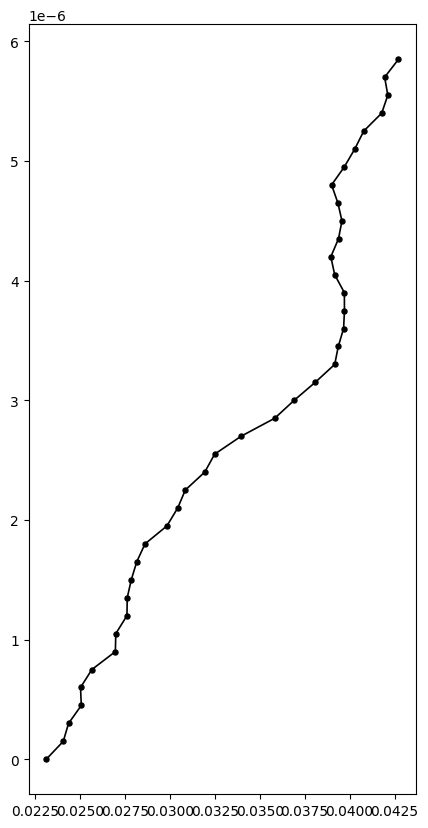

In [16]:
# plt.scatter(traces_data[1][1070:1110], np.arange(40)*timestep_data, s=5.8)
# plt.plot(traces_data[1][1070:1110], np.arange(40)*timestep_data)
# plt.axhline(9*timestep_data)
# plt.axhline(27*timestep_data)
# plt.show()

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,10)

plt.scatter(traces_data[2][1070:1110], np.arange(40)*timestep_data, s=13, color='black')
plt.plot(traces_data[2][1070:1110], np.arange(40)*timestep_data, linewidth=1.2, color = 'black')
# plt.axhline(9*timestep_data)
# plt.axhline(20*timestep_data)
plt.savefig(r"C:\Users\mct2723\Downloads\base_.png", transparent=True)
plt.show()

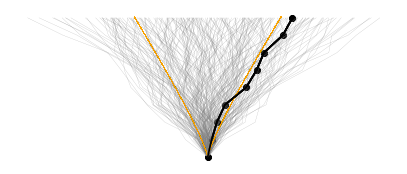

[0.         0.00094554 0.00167656 0.0024099  0.00311071 0.00378025
 0.00441801 0.00502933 0.00561452]
[0.         0.00094554 0.00167656 0.0024099  0.00311071 0.00378025
 0.00441801 0.00502933 0.00561452]
[0.         0.00094554 0.00167656 0.0024099  0.00311071 0.00378025
 0.00441801 0.00502933 0.00561452]
[0.         0.00094554 0.00167656 0.0024099  0.00311071 0.00378025
 0.00441801 0.00502933 0.00561452]
[0.         0.00094554 0.00167656 0.0024099  0.00311071 0.00378025
 0.00441801 0.00502933 0.00561452]


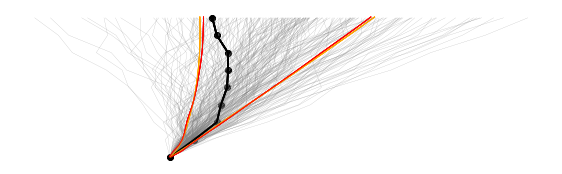

In [17]:

plt.rcParams["figure.figsize"] = (5, 2)
plt.axis('off')
plt.gca().set_frame_on(False)
for trace_idx_set in all_sub_traces_all_speeds[0]:
    for sub in trace_idx_set[:50]:
        plt.plot( (np.array(sub[:9]))/_gain, np.arange(9)*timestep_data, linewidth=.1, color='grey')
        plt.plot( np.sqrt(speeds_analytic_no_half[0][:25]), times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
        plt.plot( -np.sqrt(speeds_analytic_no_half[0][:25]),times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
    plt.plot( (traces_data[2][1079:1088]-traces_data[2][1079])/_gain, np.arange(9)*timestep_data, linewidth=1.2, color='black')
    plt.scatter( (traces_data[2][1079:1088]-traces_data[2][1079])/_gain, np.arange(9)*timestep_data, s=13, color='black')

plt.savefig(r"C:\Users\mct2723\Downloads\zero_.png", transparent=True)
plt.show()
plt.rcParams["figure.figsize"] = (7, 2)

mean_path = np.mean(all_sub_traces_all_speeds[1][0], axis=0)[:9]
mean_sqaured_path = np.mean(np.array(all_sub_traces_all_speeds[1][0])*np.array(all_sub_traces_all_speeds[1][0]), axis=0)[:9]
plt.axis('off')
plt.gca().set_frame_on(False)
from scipy.interpolate import interp1d

ff = interp1d( np.arange(9)*timestep_data, mean_path, kind='cubic',fill_value="extrapolate")
ff_sq = interp1d( np.arange(9)*timestep_data, mean_sqaured_path, kind='cubic',fill_value="extrapolate")
mean_interp = ff(times_analytic[:25])
mean_sq_interp = ff_sq(times_analytic[:25])

std = np.sqrt(mean_sq_interp - mean_interp*mean_interp)

for trace_idx_set in all_sub_traces_all_speeds[1]:
    # print(trace_idx_set[:50])

    print(mean_path)
    for sub in trace_idx_set[:50]:
        plt.plot( (np.array(sub[:9])-sub[0])/_gain, np.arange(9)*timestep_data, linewidth=.1, color='grey')
        # plt.plot( np.sqrt(speeds_analytic_no_half[1][:25]), times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
        # plt.plot( -np.sqrt(speeds_analytic_no_half[1][:25]),times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
    plt.plot( (traces_data[2][1090:1099]-traces_data[2][1090])/_gain, np.arange(9)*timestep_data, linewidth=1.2, color='black')
    plt.scatter( (traces_data[2][1090:1099]-traces_data[2][1090])/_gain, np.arange(9)*timestep_data, s=13, color='black')
    # plt.plot( (np.array(mean_path) - mean_interp[0])/_gain, np.arange(9)*timestep_data, linewidth=.6, color='orange')
    plt.plot( (np.array(mean_interp))/_gain + np.sqrt(speeds_analytic_no_half[0][:25]), times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='orange')
    plt.plot( (np.array(mean_interp))/_gain - np.sqrt(speeds_analytic_no_half[0][:25]),times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='orange')
    # THIS IS THE REAL DEF OF <x(t)>+/-sixma_x(t)
    plt.plot( (np.array(mean_interp))/_gain + std/_gain, times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='red')
    plt.plot( (np.array(mean_interp))/_gain - std/_gain, times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='red')

plt.savefig(r"C:\Users\mct2723\Downloads\one_.png", transparent=True)
plt.show()

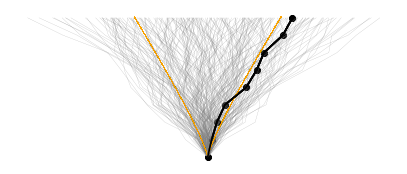

[-0.00032137  0.00062417  0.00135519  0.00208853  0.00278934  0.00345887
  0.00409664  0.00470796  0.00529315]
[-0.00032137  0.00062417  0.00135519  0.00208853  0.00278934  0.00345887
  0.00409664  0.00470796  0.00529315]
[-0.00032137  0.00062417  0.00135519  0.00208853  0.00278934  0.00345887
  0.00409664  0.00470796  0.00529315]
[-0.00032137  0.00062417  0.00135519  0.00208853  0.00278934  0.00345887
  0.00409664  0.00470796  0.00529315]
[-0.00032137  0.00062417  0.00135519  0.00208853  0.00278934  0.00345887
  0.00409664  0.00470796  0.00529315]


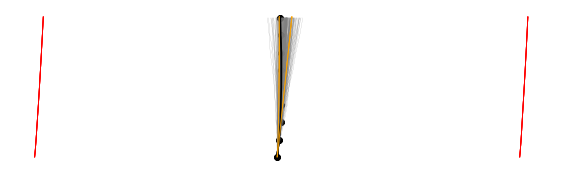

In [12]:

plt.rcParams["figure.figsize"] = (5, 2)
plt.axis('off')
plt.gca().set_frame_on(False)
for trace_idx_set in all_sub_traces_all_speeds[0]:
    for sub in trace_idx_set[:50]:
        plt.plot( (np.array(sub[:9])-sub[0])/_gain, np.arange(9)*timestep_data, linewidth=.1, color='grey')
        plt.plot( np.sqrt(speeds_analytic_no_half[0][:25]), times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
        plt.plot( -np.sqrt(speeds_analytic_no_half[0][:25]),times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
    plt.plot( (traces_data[2][1079:1088]-traces_data[2][1079])/_gain, np.arange(9)*timestep_data, linewidth=1.2, color='black')
    plt.scatter( (traces_data[2][1079:1088]-traces_data[2][1079])/_gain, np.arange(9)*timestep_data, s=13, color='black')

plt.savefig(r"C:\Users\mct2723\Downloads\zero_.png", transparent=True)
plt.show()
plt.rcParams["figure.figsize"] = (7, 2)
mean_path = np.mean(all_sub_traces_all_speeds[1][0], axis=0)[:9]
mean_sqaured_path = np.mean(np.array(all_sub_traces_all_speeds[1][0])*np.array(all_sub_traces_all_speeds[1][0]), axis=0)[:9]
plt.axis('off')
plt.gca().set_frame_on(False)
from scipy.interpolate import interp1d

ff = interp1d( np.arange(9)*timestep_data, mean_path, kind='cubic',fill_value="extrapolate")
ff_sq = interp1d( np.arange(9)*timestep_data, mean_sqaured_path, kind='cubic',fill_value="extrapolate")
mean_interp = ff(times_analytic[:25])
mean_sq_interp = ff_sq(times_analytic[:25])

std = np.sqrt(mean_sq_interp - mean_interp*mean_interp)

for trace_idx_set in all_sub_traces_all_speeds[1]:
    # print(trace_idx_set[:50])

    print(mean_path)
    for sub in trace_idx_set[:50]:
        plt.plot( (np.array(sub[:9])-sub[0])/_gain, np.arange(9)*timestep_data, linewidth=.1, color='grey')
        # plt.plot( np.sqrt(speeds_analytic_no_half[1][:25]), times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
        # plt.plot( -np.sqrt(speeds_analytic_no_half[1][:25]),times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.1, color='orange')
    plt.plot( (traces_data[2][1090:1099]-traces_data[2][1090])/_gain, np.arange(9)*timestep_data, linewidth=1.2, color='black')
    plt.scatter( (traces_data[2][1090:1099]-traces_data[2][1090])/_gain, np.arange(9)*timestep_data, s=13, color='black')
    # plt.plot( (np.array(mean_path) - mean_interp[0])/_gain, np.arange(9)*timestep_data, linewidth=.6, color='orange')
    plt.plot( (np.array(mean_interp) - mean_interp[0])/_gain + np.sqrt(speeds_analytic_no_half[0][:25]), times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='orange')
    plt.plot( (np.array(mean_interp) - mean_interp[0])/_gain - np.sqrt(speeds_analytic_no_half[0][:25]),times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='orange')
    plt.plot( (np.array(mean_interp) - mean_interp[0])/_gain + std/_gain, times_analytic[:25],label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='red')
    plt.plot( (np.array(mean_interp) - mean_interp[0])/_gain - std/_gain, times_analytic[:25], label=f"Analytical for Speed: {speeds[0]}", linewidth=.6, color='red')

plt.savefig(r"C:\Users\mct2723\Downloads\one_.png", transparent=True)
plt.show()

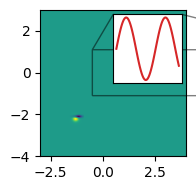

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np

fig, ax = plt.subplots()

# Load and plot main image
Z = cbook.get_sample_data("axes_grid/bivariate_normal.npy")  # 15x15 array
Z2 = np.zeros((150, 150))
ny, nx = Z.shape
Z2[30:30+ny, 30:30+nx] = Z
extent = (-3, 4, -4, 3)

ax.imshow(Z2, extent=extent, origin="lower")

# Create inset axes (position: [x0, y0, width, height] in relative coords)
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])

# Plot different data in the inset
x = np.linspace(0, 10, 100)
y = np.sin(x)
axins.plot(x, y, color='tab:red')
axins.set_xticks([])
axins.set_yticks([])

# (Optional) Don't draw zoom box since plots are unrelated
ax.indicate_inset_zoom(axins, edgecolor="black")  # REMOVE this line

plt.tight_layout()
plt.show()


tp is 5.3075664e-06
4.1015376e-06


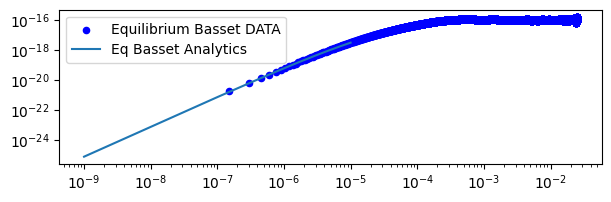

tp is 5.3075664e-06
4.1015376e-06


IndexError: list index out of range

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [14]:
# GRAPHING

basset_msd = hydro_msd(times_analytic)
# DATA GRAPHING
plt.scatter(lag_times_data[1:], eq_msd_data[1:]/_gain**2,s=20, label="Equilibrium Basset DATA", color = "blue")
plt.plot(times_analytic, basset_msd, label= "Eq Basset Analytics")
with open('../data/eq_data_sphere_3.dat', 'w') as f:
    f.write(f"# EQ DATA \n")
    data = np.column_stack((lag_times_data[1:], eq_msd_data[1:]/_gain**2))
    np.savetxt(f, data, fmt='%.15e')
with open('../data/eq_analytic_sphere_3.dat', 'w') as f:
    f.write(f"# EQ Analytic \n")
    data = np.column_stack((times_analytic, basset_msd))
    np.savetxt(f, data, fmt='%.15e')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))

init_zero_WN_analytic = just_noise(times_analytic)
analytic_tol_msds = []
for tol in tols:
    init_var_WN_analytic = known_initial_v_0(times_analytic, tol)
    analytic_tol_msds.append(init_var_WN_analytic)
WN_EQ_analytic = msd_wn(times_analytic)
basset_msd = hydro_msd(times_analytic)

def form_func(times):
    return (2/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force)) - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_5_2(times):
    return (4/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_2(times):
    return (2/100)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_3(times):
    return (1000)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(3)*(_k_b*_temp/(_m**2/_v_force))# - 2/3

def graph_2(times):
    return (np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))/550

plt.figure(figsize=(10,10))

# ANALYTIC GRAPHING
# plt.plot(times_analytic, stationairy2*_gain**2, label="stationairy 2")
# plt.plot(times_analytic, stationairy1*_gain**2, label="stationairy 1")
# plt.plot(times_analytic, laplace_form*_gain**2, linewidth=4, label="inital zero basset", color='green')
# plt.plot(times_analytic, averaged_initial_msd*_gain**2, label="cole FORM2")
# plt.scatter(times_analytic, laplace_form2*_gain**2, s=.2, label="cole FORM2")
# plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)]))*_gain**2, label="5/2", color='black', linewidth=3)
# plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_2(np.array(times_analytic[30:int(len(times_analytic)/7)]))*_gain**2, label="2", color='black', linewidth=3)
# plt.plot(times_analytic, init_zero_WN_analytic*_gain**2, linestyle='dashed', label="Initial Zero White")
# plt.plot(times_analytic, analytic_tol_msds[0], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[0]}")
# for i in range(len(tols)):
#     plt.plot(times_analytic, analytic_tol_msds[i], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[i]}")
# plt.plot(times_analytic, WN_EQ_analytic*_gain**2, linestyle='dashed', label="Equilibrium White")
# plt.plot(times_analytic, basset_msd, color='green', linewidth=4,label="Equilibrium Basset")

# SIMULATION GRAPHING
# plt.plot(lag_times_sim[1:10000], eq_msd_sim[1:10000]*_gain**2, color = "red", label="Equilibrium Basset SIM")
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[-1][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[0]}")
# for i in range(len(tols)):
    # plt.plot(init_lag_times_sim[40:], sim_tol_msds[i][40:]*_gain**2, linestyle = 'dashed', color = "red", label=f"Initial Variable Basset Variance Basset SIM tol={tols[i]}")

# SPEEDS
for i in range(0, len(speeds)):
    # plt.plot(lag_times_speed_sim[1:], sim_speeds_msds[i][1:], linestyle = 'dashed', label=f"Speed Basset Variance Basset SIM speed={speeds[i]}")
    plt.errorbar(lag_times_speed_data[1:], data_speeds_msds[i][1:]/_gain**2, yerr = error_bar_speeds[i][1:]/_gain**2, marker='o', markersize=1, label=f"Data for Speed: {speeds[i]}")
    # plt.plot(times_analytic, speeds_analytic[i]*_gain**2, label=f"speed {speeds[i]} basset form")
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")

plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("Conditioning on variable velocities")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# ZERO PLOT
plt.figure(figsize=(10,10))
plt.plot(lag_times_speed_data[1:], data_speeds_msds[0][1:]/_gain**2, linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
plt.plot(times_analytic, form_func(times_analytic), label= "Short Time Derivation")
plt.plot(times_analytic, speeds_analytic_no_half[0], label=f"v(0) = 0 Analytics")
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="5/2", color='black', linewidth=1)
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_3(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="3", color='black', linewidth=1)
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_2(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="3", color='black', linewidth=1)
plt.title("Super Balistic Hydrodynamics")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")

with open('../data/data_speeds_sphere_3.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Traces used {traces_per_speed[i]} | Speed {speeds[i]}\n")
        data = np.column_stack((lag_times_speed_data[1:], data_speeds_msds[i][1:] / _gain**2))
        np.savetxt(f, data, fmt='%.15e')

with open('../data/analytic_speeds_sphere_3.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Speed {speeds[i]}\n")
        data = np.column_stack((times_analytic, speeds_analytic_no_half[i]))
        np.savetxt(f, data, fmt='%.15e')

with open('../data/data_error_bars_sphere_3.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Traces used {traces_per_speed[i]} | Speed {speeds[i]}\n")
        data = np.column_stack((lag_times_speed_data[1:], error_bar_speeds[i][1:]/_gain**2))
        np.savetxt(f, data, fmt='%.15e')


plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# plt.plot(init_lag_times_data, data_tol_msds[0], linestyle='dotted', label=f"Initial Variable Basset Variance Basset DATA tol={tols[0]}")
# for i in range(len(tols)):
    # plt.scatter(init_lag_times_data, data_tol_msds[i], s=20, color = "blue", label=f"Initial Variable Basset Variance Basset DATA tol={tols[i]}")

# data = np.column_stack((init_lag_times_data, data_tol_msds[0]))
# a_form = np.column_stack((times_analytic, laplace_form*_gain**2))
# eq_data = np.column_stack((lag_times_data[1:], eq_msd_data[1:]))
# eq_form = np.column_stack((times_analytic, basset_msd*_gain**2))

# Save to a text file
# np.savetxt('../data/data.dat', data, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/a_form.dat', a_form, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/eq_data_old.dat', eq_data, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/eq_form.dat', eq_form, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc

# High precision for inverse Laplace
mp.dps = 30

roots = [108.66994871+196.31569885j, 108.66994871-196.31569885j,
         -9.77032846 +66.56826441j,  -9.77032846 -66.56826441j]

# History term in Laplace domain - see overlead doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 2/sqrt(-tau) - 2 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))
    
# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1
N = 100
tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace
z = 3*_r**2*np.sqrt(np.pi*_viscous*_rho_f)

# Fixed t value at which to evaluate MSD_history(t) importance
t_evals = np.logspace(-6.5, -1.5, 20)
msd_hs = []

for t_eval in t_evals:
    # Compute f(t, tau) for all tau
    f_vals = np.array([f(t_eval, tau) for tau in tau_array]) # tau is backwards time, t_eval is forwards

    # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
    T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
    f1 = f_vals[:, np.newaxis]
    f2 = f_vals[np.newaxis, :]
    VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aprroximate strength of the VACF given the lag time between T1 and T2...
    integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...

    # Integrate over tau1 and tau2
    msd_history = trapz(trapz(integrand, tau_array, axis=1), tau_array)
    # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
    msd_hs.append(msd_history*z**2)

plt.plot(t_evals, msd_hs, linestyle='dashed', label="g")
plt.plot(times_analytic, speeds_analytic_no_half[0], label = "msd")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.show()